# Positional Embedding

Unlike RNNs, transformers take all the input at once, not sequentially. So, we don't know the order of the words, which why we use "Positional Embedding".

Why do we use sine and cosine?
1. Periodicity: a word can pay attention to let's say 5 word after it, then 10, 15, 20, ...
2. Constrained value: the value of the embedding is between -1 and 1, which is good for the attention mechanism.
3. Easy to extrapolate: deterministic function. Even if we haven't seen a word, we can still predict its embedding.

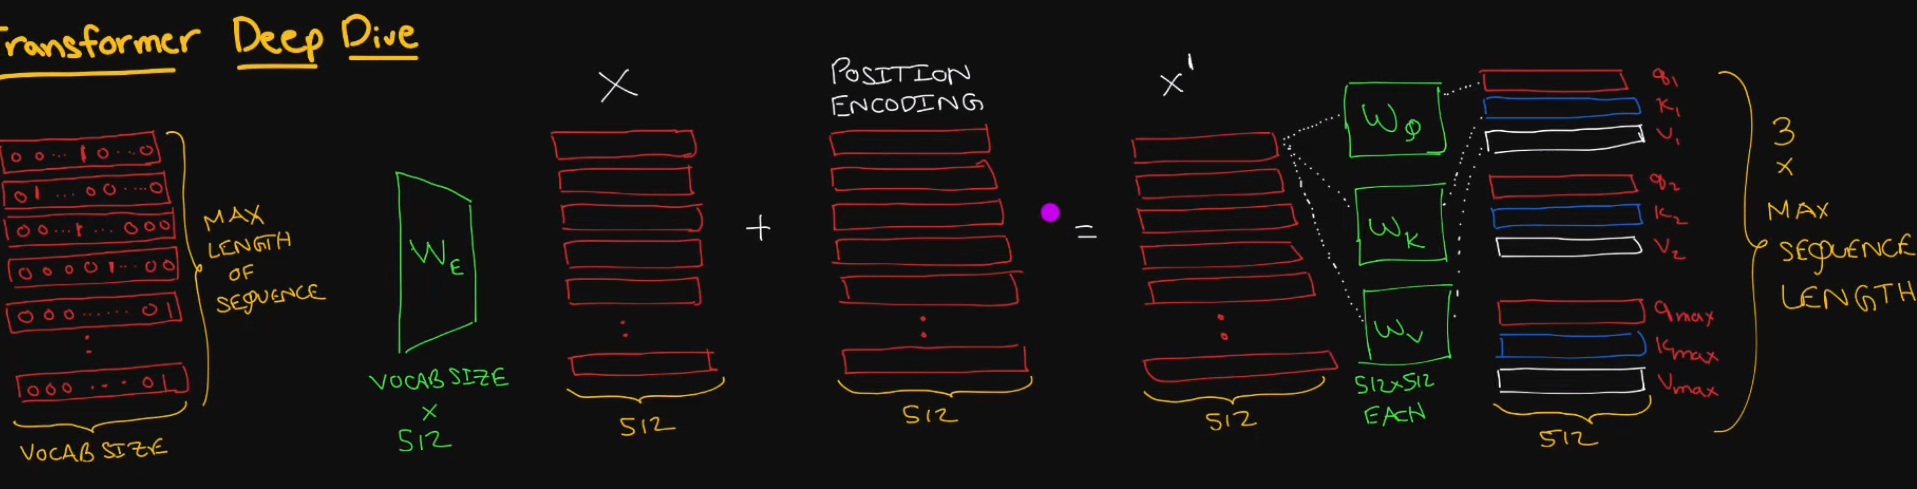

$$
\begin{aligned}
\text PE_{(pos, 2i)} &=\operatorname{sin} \left(\frac{pos} {10000^{2i / d_{model}}} \right) \\
\text PE_{(pos, 2i+1)} &=\operatorname{cos} \left(\frac{pos} {10000^{2i / d_{model}}} \right) \\
\end{aligned}
$$

Simplified formula:

$$
\begin{aligned}
\text PE_{(pos, i)} &=\operatorname{sin} \left(\frac{pos} {10000^{i / d_{model}}} \right) when \ i \ is \ even \\
\text PE_{(pos, i)} &=\operatorname{cos} \left(\frac{pos} {10000^{i-1 / d_{model}}} \right) when \ i \ is \ odd \\
\end{aligned}
$$

where $pos$ is the position and $i$ is the embedding dimension.

In [1]:
import torch
import torch.nn as nn

max_sequence_length = 10    # Much bigger in reality (thousands)
d_model = 6                 # Embedding dim: Original is 512

In [2]:
enven_i = torch.arange(0, d_model, 2).float()
enven_denominator = 10000 ** (enven_i / d_model)
enven_i, enven_denominator

(tensor([0., 2., 4.]), tensor([  1.0000,  21.5443, 464.1590]))

In [3]:
odd_i = torch.arange(1, d_model, 2).float()
odd_denominator = torch.pow(10000, ((odd_i-1) / d_model))
odd_i, odd_denominator

(tensor([1., 3., 5.]), tensor([  1.0000,  21.5443, 464.1590]))

Even and odd denominator are the same because the odd_i is one more than even_i, and we substract 1 in the denimator, so the result becomes the same.

In [4]:
denominator = odd_denominator
position = torch.arange(0, max_sequence_length)
print(position.shape)
# Reshape the position so that we have 1 position for each word
position = position.reshape(-1, 1)      # -1 == max_sequence_length
print(position.shape)
position

torch.Size([10])
torch.Size([10, 1])


tensor([[0],
        [1],
        [2],
        [3],
        [4],
        [5],
        [6],
        [7],
        [8],
        [9]])

In [5]:
denominator

tensor([  1.0000,  21.5443, 464.1590])

position has a shape of (10, 1) and denominator has a shape of (1, 3), so the result has a shape of (10, 3).

In [6]:
position / denominator

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 4.6416e-02, 2.1544e-03],
        [2.0000e+00, 9.2832e-02, 4.3089e-03],
        [3.0000e+00, 1.3925e-01, 6.4633e-03],
        [4.0000e+00, 1.8566e-01, 8.6177e-03],
        [5.0000e+00, 2.3208e-01, 1.0772e-02],
        [6.0000e+00, 2.7850e-01, 1.2927e-02],
        [7.0000e+00, 3.2491e-01, 1.5081e-02],
        [8.0000e+00, 3.7133e-01, 1.7235e-02],
        [9.0000e+00, 4.1774e-01, 1.9390e-02]])

In [7]:
# pos_embedding = torch.sin(position / (10000 ** (enven_i / d_model)))
even_PE = torch.sin(position / denominator)
odd_PE = torch.cos(position / denominator)
even_PE, odd_PE

(tensor([[ 0.0000,  0.0000,  0.0000],
         [ 0.8415,  0.0464,  0.0022],
         [ 0.9093,  0.0927,  0.0043],
         [ 0.1411,  0.1388,  0.0065],
         [-0.7568,  0.1846,  0.0086],
         [-0.9589,  0.2300,  0.0108],
         [-0.2794,  0.2749,  0.0129],
         [ 0.6570,  0.3192,  0.0151],
         [ 0.9894,  0.3629,  0.0172],
         [ 0.4121,  0.4057,  0.0194]]),
 tensor([[ 1.0000,  1.0000,  1.0000],
         [ 0.5403,  0.9989,  1.0000],
         [-0.4161,  0.9957,  1.0000],
         [-0.9900,  0.9903,  1.0000],
         [-0.6536,  0.9828,  1.0000],
         [ 0.2837,  0.9732,  0.9999],
         [ 0.9602,  0.9615,  0.9999],
         [ 0.7539,  0.9477,  0.9999],
         [-0.1455,  0.9318,  0.9999],
         [-0.9111,  0.9140,  0.9998]]))

Remember that the even_i is for even number (0, 2, ...) and the odd_i is for odd number (1, 3, ...). So to get the complete positional embedding, we need to concatenate the even_i and odd_i one after the other.

In [8]:
even_PE.shape, odd_PE.shape

(torch.Size([10, 3]), torch.Size([10, 3]))

In [9]:
stacked = torch.stack((even_PE, odd_PE), dim=2)
print(stacked.shape)
stacked

torch.Size([10, 3, 2])


tensor([[[ 0.0000,  1.0000],
         [ 0.0000,  1.0000],
         [ 0.0000,  1.0000]],

        [[ 0.8415,  0.5403],
         [ 0.0464,  0.9989],
         [ 0.0022,  1.0000]],

        [[ 0.9093, -0.4161],
         [ 0.0927,  0.9957],
         [ 0.0043,  1.0000]],

        [[ 0.1411, -0.9900],
         [ 0.1388,  0.9903],
         [ 0.0065,  1.0000]],

        [[-0.7568, -0.6536],
         [ 0.1846,  0.9828],
         [ 0.0086,  1.0000]],

        [[-0.9589,  0.2837],
         [ 0.2300,  0.9732],
         [ 0.0108,  0.9999]],

        [[-0.2794,  0.9602],
         [ 0.2749,  0.9615],
         [ 0.0129,  0.9999]],

        [[ 0.6570,  0.7539],
         [ 0.3192,  0.9477],
         [ 0.0151,  0.9999]],

        [[ 0.9894, -0.1455],
         [ 0.3629,  0.9318],
         [ 0.0172,  0.9999]],

        [[ 0.4121, -0.9111],
         [ 0.4057,  0.9140],
         [ 0.0194,  0.9998]]])

Now we flatten the array the array on the first dimension, so that we get a shape of (10, 6) representing the 10 words and the embedding dimension of 6.<br>
This complete the concatenation of the odd and even positional embedding.

In [10]:
PE = torch.flatten(stacked, start_dim=1, end_dim=2)
print(PE.shape)
PE

torch.Size([10, 6])


tensor([[ 0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000],
        [ 0.8415,  0.5403,  0.0464,  0.9989,  0.0022,  1.0000],
        [ 0.9093, -0.4161,  0.0927,  0.9957,  0.0043,  1.0000],
        [ 0.1411, -0.9900,  0.1388,  0.9903,  0.0065,  1.0000],
        [-0.7568, -0.6536,  0.1846,  0.9828,  0.0086,  1.0000],
        [-0.9589,  0.2837,  0.2300,  0.9732,  0.0108,  0.9999],
        [-0.2794,  0.9602,  0.2749,  0.9615,  0.0129,  0.9999],
        [ 0.6570,  0.7539,  0.3192,  0.9477,  0.0151,  0.9999],
        [ 0.9894, -0.1455,  0.3629,  0.9318,  0.0172,  0.9999],
        [ 0.4121, -0.9111,  0.4057,  0.9140,  0.0194,  0.9998]])

## Test the class

In [11]:
from src.PostionalEmbedding import PositionalEmbedding

pe = PositionalEmbedding(embedding_dim=6, max_sequence_length=10)
pe.forward()

tensor([[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
          1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,
          0.0000e+00,  1.0000e+00],
        [-9.9749e-01, -7.0741e-02,  4.6416e-04,  1.0000e+00,  4.6416e-08,
          1.0000e+00,  4.6416e-12,  1.0000e+00,  4.6416e-16,  1.0000e+00,
          4.6416e-20,  1.0000e+00],
        [ 1.4113e-01, -9.8999e-01,  9.2832e-04,  1.0000e+00,  9.2832e-08,
          1.0000e+00,  9.2832e-12,  1.0000e+00,  9.2832e-16,  1.0000e+00,
          9.2832e-20,  1.0000e+00],
        [ 9.7753e-01,  2.1081e-01,  1.3925e-03,  1.0000e+00,  1.3925e-07,
          1.0000e+00,  1.3925e-11,  1.0000e+00,  1.3925e-15,  1.0000e+00,
          1.3925e-19,  1.0000e+00],
        [-2.7943e-01,  9.6017e-01,  1.8566e-03,  1.0000e+00,  1.8566e-07,
          1.0000e+00,  1.8566e-11,  1.0000e+00,  1.8566e-15,  1.0000e+00,
          1.8566e-19,  1.0000e+00],
        [-9.3799e-01, -3.4665e-01,  2.3208e-03,  1.0000e+00,  2.3208e-07,
      